In [0]:
!pip install turicreate
!pip install lifetimes

In [0]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import sys
sys.path.append("..")
## Algoritmos de ML
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree
import graphviz 
from sklearn import metrics

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing

## Codificación de caracteristicas
#from sklearn import preprocessing

In [0]:
url = 'https://github.com/masdatascience/TFM-AI/blob/master/datos.xlsx?raw=true'
datos_modelo = pd.ExcelFile(url)

In [0]:
datos_facturacion = pd.read_excel(datos_modelo, sheet_name='fac_txn')
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
datos_facturacion = datos_facturacion.dropna(subset=['customer_id'])
datos_facturacion = datos_facturacion.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
datos_facturacion = datos_facturacion.loc[datos_facturacion['total_value'] > 0]
# Se descarcatan las ordenes que han sido canceladas
#datos_facturacion = datos_facturacion.loc[datos_facturacion['order_status'] != 'canceled']
print(datos_facturacion.shape)
datos_producto = pd.read_excel(datos_modelo, sheet_name='product')
datos_clientes = pd.read_excel(datos_modelo, sheet_name='customer')
print(datos_producto.shape)
datos_facturacion.head()

(10000, 22)
(6088, 10)


,order_id,order_item_id,product_id,customer_id,customer_zip_code_prefix,seller_id,shipping_limit_date,price,freight_value,total_value,credit_card,debit_card,boleto,voucher,not_defined,num_txn,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,871766c5855e863f6eccc05f988b23cb,28013,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,5890,1329,7219,7219,0,0,0,0,1,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,eb28e67c4c0b83846050ddfb8a35d051,15775,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,23990,1993,25983,25983,0,0,0,0,1,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,3818d81c6709e39d06b2738a8d3a2474,35661,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,19900,1787,21687,21687,0,0,0,0,1,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,af861d436cfc08b2c2ddefd0ba074622,12952,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,1299,1279,2578,2578,0,0,0,0,1,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,64b576fb70d441e8f1b2d7d446e483c5,13226,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,19990,1814,21804,21804,0,0,0,0,1,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


## 1. MOTOR DE RECOMENDACIÓN

In [0]:
matrix_usuario_producto =pd.crosstab(datos_facturacion['customer_id'],datos_facturacion['product_id'],values=datos_facturacion['total_value'], aggfunc='sum', margins=True, margins_name="total_value")
matrix_usuario_producto.head()



product_id,0009406fd7479715e4bef61dd91f2462,001b72dfd63e9833e8c02742adf472e3,002c6dab60557c48cfd6c2222ef7fd76,0030e635639c898b323826589761cf23,004636c889c7c3dad6631f136b7fa082,005030ef108f58b46b78116f754d8d38,006baa9a5b8f95895f15273a35bc2664,008cff0e5792219fae03e570f980b330,00905d58c87afcbce21420b3712cacaa,00917855135d67fb060dcd81863166a4,00929aaa7751a77220db9caa1ae6d3ab,00989337a1916a0055eedd1fdb35eb53,009af1277432f1a05742df69cdf72d1e,00ab8a8b9fe219511dc3f178c6d79698,00ba6d766f0b1d7b78a5ce3e1e033263,00baba5b58e274d0332a0c8a0a66f877,00cc15e0cef551848c797ab75ba904b1,00dc8a1b2de45a7fca5921544e5f351d,00de7f393d962717eeeb2d7131a40dba,00faa46f36261af8bbf3a4d37fa4841b,00fefaf41156bb4b0d850fb27da97897,00ffe57f0110d73fd84d162252b2c784,0103208eb1ea5a1a7359c0251a65e37a,011967a30ceeaa86acb72e79664544ad,0127db1f4effcf8f5b88d80588bc5624,013ee64977aaa6b2b25475095162e0e9,014a8a503291921f7b004a5215bb3c36,0152f69b6cf919bcdaf117aa8c43e5a2,01545847403c0f1e69d76654d66be35c,0164201c7c8b81dc5779e015e2d7be59,016711f78a6a87696645db0a6a834826,016cae136d358dcdacbd7ac9f1864c09,017692475c1c954ff597feda05131d73,0176bf7839ab4e611dc01cdc3ef6f4e4,01a5038835acf17f141c7247956b72d6,01a88bd2633c52bcc66348307cb3ae15,01b0238705b6ae8e35c6fea837e6ae4a,01bacce2c74317ed2524bcaabae2e9d4,01c666c82f414c762ad21bffa56e8b49,01c9a70868bec5b748c67fcc26ce5895,...,fe61253e50ad6ee9f1d180da22ce5eef,fe6a9515d655fa7936b8a7c841039f34,fe75529a267b76ac6e96f0c322a899a4,fe7ad3e3828f32193dfbe6359f733a8f,fe9dfbe7f974621789683b7b78be2a16,fea7f0c147905a41ca324c0e3234a4c7,fec3b45dc09b257690a09a742870b149,fec85e6c0eab9b4bcddf9ccd917c80bc,fecf6223a3494f35362f670e571d2a04,fed2dca7ba471a3942a070e00ae17381,fed5c40c27e1c88560a9e92d82ee0825,fedbf77eb491dfc9ac276b9ea9ee10c6,feddfbd2585f9007f7ed77b1d1ae8d80,fef0296e6442db59700c92c692c90e90,ff28477a5bcb2fc34bb86a6c2eea1566,ff29d8cb1cd0cd5ea37b80dac9939e1c,ff2b293ae4b3c204113bdec91e27a584,ff415a8a6bfbaf8244f4ee0c7c30d905,ff4f5b008c32f80c3f952b2b56a28e04,ff5d87897ed26d564711df324b98ebee,ff5ecb2f7628793844e861076ab8e467,ff5f8606556b625613f069a5a9a48966,ff6caf9340512b8bf6d2a2a6df032cfa,ff7aa48b8bc68495866b40c4010d58c9,ff7fccf8513f360157f0660fe51d1d88,ff8bd09f659b88af06fdfea61a8b7b45,ff9032482857269e8683f0c2f8ba4709,ff92ca9bb0b3f4ec00a9b76c9f68cb3a,ff95ac47246ef13e48712ea1ff8df0d9,ff96895c6b1d31f34b2d82f86670fa85,ffb2e8c1ddc7c3e590d2bc4c91de53e1,ffbc83054b3741a8d67fc59d9cf9d42d,ffbfa9e143fda4420454d0f4e88a3cd5,ffc0b406806006602c5853b00ab5f7fd,ffc9caf33e2d1e9f44e3e06da19085f7,ffccf0ce5eff1a158891296990107d08,ffd34459c21034d1da6df9800de0d7a3,ffd4bf4306745865e5692f69bd237893,ffd63ee42a5c8cc5a15a1c8e2aa50011,total_value
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0005ef4cd20d2893f0d9fbd94d3c0d97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12976
001ae5a1788703d64536c30362503e49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13508
0027324a96d26a2bc7d69262f83c8403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4678
003035f5ec76f2220098377482de93c9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,

In [0]:
matrix_usuario_producto_norm = (matrix_usuario_producto-matrix_usuario_producto.min())/(matrix_usuario_producto.max()-matrix_usuario_producto.min())

In [0]:
# Se crea una tabla como resultado de la normalización  
d = matrix_usuario_producto_norm.reset_index() 
d.index.names = ['value_freq'] 
data_norm = pd.melt(d, id_vars=['customer_id'], value_name='value_freq').dropna()
print(data_norm.shape)
data_norm.head()

(14312, 3)


,customer_id,product_id,value_freq
13281,82a942ca919e963244fbf83c6ae50ab7,001b72dfd63e9833e8c02742adf472e3,0.019964
14960,b2ff6bd1b406f81f3cfe08aa6e75414b,001b72dfd63e9833e8c02742adf472e3,0.000000
17551,total_value,001b72dfd63e9833e8c02742adf472e3,1.000000
64907,657e052d73bd797f2bebba4996558e12,008cff0e5792219fae03e570f980b330,0.000000
69731,f0e4503675216b3763cac5b231b4c053,008cff0e5792219fae03e570f980b330,0.042893


In [0]:
## dummy
datos_dummy = datos_facturacion.copy()
datos_dummy['total_dummy'] = 1
datos_dummy.head()



,order_id,order_item_id,product_id,customer_id,customer_zip_code_prefix,seller_id,shipping_limit_date,price,freight_value,total_value,credit_card,debit_card,boleto,voucher,not_defined,num_txn,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,total_dummy
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,871766c5855e863f6eccc05f988b23cb,28013,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,5890,1329,7219,7219,0,0,0,0,1,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,eb28e67c4c0b83846050ddfb8a35d051,15775,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,23990,1993,25983,25983,0,0,0,0,1,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,3818d81c6709e39d06b2738a8d3a2474,35661,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,19900,1787,21687,21687,0,0,0,0,1,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,af861d436cfc08b2c2ddefd0ba074622,12952,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,1299,1279,2578,2578,0,0,0,0,1,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,64b576fb70d441e8f1b2d7d446e483c5,13226,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,19990,1814,21804,21804,0,0,0,0,1,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1


In [0]:
# genero particionamiento de los conjuntos a usar
train_data, test_data  = train_test_split(datos_facturacion, test_size=0.2 ,random_state=1)
train_data_dummy, test_data_dummy = train_test_split(datos_dummy, test_size=0.2 ,random_state=1)
train_data_norm, test_data_norm = train_test_split(data_norm, test_size=0.2 ,random_state=1)

##Colaborativo

In [0]:
# se definen parametros para recomendar el nu´meruo de productos a recomendar y una previsualziación definida del resultado
user_id = 'customer_id'
item_id = 'product_id'
users_to_recommend = list(datos_clientes[user_id])
n_rec = 5 # number of items to recommend
n_display = 15 # to display the first few rows in an output dataset

In [0]:
# Se define una función que retorne un modelo resultado segun el enfoque que se requiere:
# 1. Popularity : Es el item que más se a consumido en todos los clientes
# 2. cosine :
# 3. Pearson: 
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

## Producto más comprado

In [0]:
name = 'popularity'
target = 'total_value'
train_dataF=tc.SFrame(train_data)
test_dataF=tc.SFrame(test_data)
popularity_model = model(train_dataF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns order_id, order_item_id, customer_zip_code_prefix, seller_id, shipping_limit_date, price, freight_value, credit_card, debit_card, boleto, voucher, not_defined, num_txn, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 8000 observations with 7145 users and 5152 items.

Data prepared in: 0.029726s

8000 observations to process; with 5152 unique items.

recommendations finished on 1000/8823 queries. users per second: 80495.9

recommendations finished on 2000/8823 queries. users per second: 80834.2

recommendations finished on 3000/8823 queries. users per second: 81100.8

recommendations finished on 4000/8823 queries. users per second: 81328.9

recommendations finished on 5000/8823 queries. users per second: 80195

recommendations finished on 6000/8823 queries. users per second: 80026.7

recommendations finished on 7000/8823 queries. users per second: 75291.5

recommendations finished on 8000/8823 queries. users per second: 70643.9

+-------------------------------+-------------------------------+----------+------+
|          customer_id          |           product_id          |  score   | rank |
+-------------------------------+-------------------------------+----------+------+
| 0005ef4cd20d2893f0d9fbd94d... | 34f99d82cfc355d08d8db780d1... | 312650.0 |  1   |
| 0005ef4cd20d2893f0d9fbd94d... | a233df9a388d27dbdfd31731d4... | 278416.0 |  2   |
| 0005ef4cd20d2893f0d9fbd94d... | a3cd9517ebf5a50dca25acce54... | 271336.0 |  3   |
| 0005ef4cd20d2893f0d9fbd94d... | ada6a9116c85d8e56232e0a426... | 232522.0 |  4   |
| 0005ef4cd20d2893f0d9fbd94d... | 8a12c0e223d9dbd49ccfcd2ad2... | 218742.0 |  5   |
| 001ae5a1788703d64536c30362... | 34f99d82cfc355d08d8db780d1... | 312650.0 |  1   |
| 001ae5a1788703d64536c30362... | a233df9a388d27dbdfd31731d4... | 278416.0 |  2   |
| 001ae5a1788703d64536c30362... | a3cd9517ebf5a50dca25acce54... | 271336.0 |  3   |
| 001ae5a1788703d64536c30362... | ada6a9116c85d8e56232e0a426... | 232522.0 |

In [0]:
name = 'popularity'
target = 'total_dummy'
train_data_dummyF=tc.SFrame(train_data_dummy)
test_data_dummyF=tc.SFrame(test_data_dummy)
pop_dummy = model(train_data_dummyF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns order_id, order_item_id, customer_zip_code_prefix, seller_id, shipping_limit_date, price, freight_value, total_value, credit_card, debit_card, boleto, voucher, not_defined, num_txn, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 8000 observations with 7145 users and 5152 items.

Data prepared in: 0.026324s

8000 observations to process; with 5152 unique items.

recommendations finished on 1000/8823 queries. users per second: 75171

recommendations finished on 2000/8823 queries. users per second: 76746

recommendations finished on 3000/8823 queries. users per second: 77010

recommendations finished on 4000/8823 queries. users per second: 77839.2

recommendations finished on 5000/8823 queries. users per second: 77093.9

recommendations finished on 6000/8823 queries. users per second: 77797.8

recommendations finished on 7000/8823 queries. users per second: 75184.7

recommendations finished on 8000/8823 queries. users per second: 71729.6

+-------------------------------+-------------------------------+-------+------+
|          customer_id          |           product_id          | score | rank |
+-------------------------------+-------------------------------+-------+------+
| 0005ef4cd20d2893f0d9fbd94d... | 89e4362d74afa10ac57f8d6721... |  1.0  |  1   |
| 0005ef4cd20d2893f0d9fbd94d... | c0380894bd866c75c47c00359d... |  1.0  |  2   |
| 0005ef4cd20d2893f0d9fbd94d... | 6f3b5b605d91b7439c5e3f5a8d... |  1.0  |  3   |
| 0005ef4cd20d2893f0d9fbd94d... | 2a478a360a293f087e352e88f1... |  1.0  |  4   |
| 0005ef4cd20d2893f0d9fbd94d... | 2d27434c710806b971a721da33... |  1.0  |  5   |
| 001ae5a1788703d64536c30362... | 89e4362d74afa10ac57f8d6721... |  1.0  |  1   |
| 001ae5a1788703d64536c30362... | c0380894bd866c75c47c00359d... |  1.0  |  2   |
| 001ae5a1788703d64536c30362... | 6f3b5b605d91b7439c5e3f5a8d... |  1.0  |  3   |
| 001ae5a1788703d64536c30362... | 2a478a360a293f087e352e88f1... |  1.0  |  4   |
| 001ae5a1788703d64536c30362

In [0]:
name = 'popularity'
target = 'value_freq'
train_data_normF=tc.SFrame(train_data_norm)
test_data_normF=tc.SFrame(test_data_norm)
pop_norm = model(test_data_normF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 2863 observations with 2456 users and 719 items.

Data prepared in: 0.009644s

2863 observations to process; with 719 unique items.

recommendations finished on 1000/8823 queries. users per second: 239808

recommendations finished on 2000/8823 queries. users per second: 263227

recommendations finished on 3000/8823 queries. users per second: 289995

recommendations finished on 4000/8823 queries. users per second: 301500

recommendations finished on 5000/8823 queries. users per second: 300102

recommendations finished on 6000/8823 queries. users per second: 261051

recommendations finished on 7000/8823 queries. users per second: 262802

recommendations finished on 8000/8823 queries. users per second: 257583

+-------------------------------+-------------------------------+-------+------+
|          customer_id          |           product_id          | score | rank |
+-------------------------------+-------------------------------+-------+------+
| 0005ef4cd20d2893f0d9fbd94d... | afeeea6271148ee1bb15173b81... |  1.0  |  1   |
| 0005ef4cd20d2893f0d9fbd94d... | 3439529926df110506c6752e8f... |  1.0  |  2   |
| 0005ef4cd20d2893f0d9fbd94d... | eef3286d1162cb7eb46becab2a... |  1.0  |  3   |
| 0005ef4cd20d2893f0d9fbd94d... | 07c055536ebf10dfbb6c6db6db... |  1.0  |  4   |
| 0005ef4cd20d2893f0d9fbd94d... | fb7a100ec8c7b34f60cec22b1a... |  1.0  |  5   |
| 001ae5a1788703d64536c30362... | afeeea6271148ee1bb15173b81... |  1.0  |  1   |
| 001ae5a1788703d64536c30362... | 3439529926df110506c6752e8f... |  1.0  |  2   |
| 001ae5a1788703d64536c30362... | eef3286d1162cb7eb46becab2a... |  1.0  |  3   |
| 001ae5a1788703d64536c30362... | 07c055536ebf10dfbb6c6db6db... |  1.0  |  4   |
| 001ae5a1788703d64536c30362

Se identifica que el primer modelo genera los mismos valores ya es basado en la popularidad de todos los clientes y por ende es la misma recomendación para todos. De hecho si se agrupan los productos porel más vendido, se puede ver a continuación que tiene coherencia.


In [0]:
train_data.groupby(by='product_id')['total_value'].mean().sort_values(ascending=False).head()

product_id
34f99d82cfc355d08d8db780d14aa002    312650.0
a233df9a388d27dbdfd31731d4236db0    278416.0
a3cd9517ebf5a50dca25acce54f3b171    271336.0
ada6a9116c85d8e56232e0a4265d7db9    232522.0
8a12c0e223d9dbd49ccfcd2ad25d1b30    218742.0
Name: total_value, dtype: float64

## Colaborativo
Se evaluarán dos enfoques la distancia coseno y Pearson
### Coseno

In [0]:
name = 'cosine'
target = 'total_value'
cos = model(train_dataF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns order_id, order_item_id, customer_zip_code_prefix, seller_id, shipping_limit_date, price, freight_value, credit_card, debit_card, boleto, voucher, not_defined, num_txn, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 8000 observations with 7145 users and 5152 items.

Data prepared in: 0.02511s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 216us                          | 13.75      |

| 2.102ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 29.905ms                            | 0                | 2               |

| 157.098ms                           | 100              | 5152            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.161047s

recommendations finished on 1000/8823 queries. users per second: 44851.1

recommendations finished on 2000/8823 queries. users per second: 47489

recommendations finished on 3000/8823 queries. users per second: 48681.5

recommendations finished on 4000/8823 queries. users per second: 49123.8

recommendations finished on 5000/8823 queries. users per second: 49510.3

recommendations finished on 6000/8823 queries. users per second: 49197.7

recommendations finished on 7000/8823 queries. users per second: 48528.9

recommendations finished on 8000/8823 queries. users per second: 44189.9

+-------------------------------+-------------------------------+
|          customer_id          |           product_id          |
+-------------------------------+-------------------------------+
| 0005ef4cd20d2893f0d9fbd94d... | 2b2d98d1e9b6f68a472c5ace64... |
| 0005ef4cd20d2893f0d9fbd94d... | 481aad97c80d6786a7c6096991... |
| 0005ef4cd20d2893f0d9fbd94d... | 2f70195374f6c3d3c6542edf5b... |
| 0005ef4cd20d2893f0d9fbd94d... | 89e4362d74afa10ac57f8d6721... |
| 0005ef4cd20d2893f0d9fbd94d... | c0380894bd866c75c47c00359d... |
| 001ae5a1788703d64536c30362... | 2b2d98d1e9b6f68a472c5ace64... |
| 001ae5a1788703d64536c30362... | 481aad97c80d6786a7c6096991... |
| 001ae5a1788703d64536c30362... | 2f70195374f6c3d3c6542edf5b... |
| 001ae5a1788703d64536c30362... | 89e4362d74afa10ac57f8d6721... |
| 001ae5a1788703d64536c30362... | c0380894bd866c75c47c00359d... |
| 0027324a96d26a2bc7d69262f8... | 2b2d98d1e9b6f68a472c5ace64... |
| 0027324a96d26a2bc7d69262f8... | 481aad97c80d6786a7c6096991... |
| 0027324a

In [0]:
name = 'cosine'
target = 'total_dummy'
cos_dummy = model(train_data_dummyF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns order_id, order_item_id, customer_zip_code_prefix, seller_id, shipping_limit_date, price, freight_value, total_value, credit_card, debit_card, boleto, voucher, not_defined, num_txn, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 8000 observations with 7145 users and 5152 items.

Data prepared in: 0.025575s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 310us                          | 13.75      |

| 811us                          | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 30.244ms                            | 0                | 2               |

| 129.49ms                            | 100              | 5152            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.135843s

recommendations finished on 1000/8823 queries. users per second: 53222.6

recommendations finished on 2000/8823 queries. users per second: 52426

recommendations finished on 3000/8823 queries. users per second: 51089

recommendations finished on 4000/8823 queries. users per second: 51223.6

recommendations finished on 5000/8823 queries. users per second: 51260.5

recommendations finished on 6000/8823 queries. users per second: 51166.6

recommendations finished on 7000/8823 queries. users per second: 49390.7

recommendations finished on 8000/8823 queries. users per second: 46350.7

+-------------------------------+-------------------------------+-------+------+
|          customer_id          |           product_id          | score | rank |
+-------------------------------+-------------------------------+-------+------+
| 0005ef4cd20d2893f0d9fbd94d... | 89e4362d74afa10ac57f8d6721... |  0.0  |  1   |
| 0005ef4cd20d2893f0d9fbd94d... | c0380894bd866c75c47c00359d... |  0.0  |  2   |
| 0005ef4cd20d2893f0d9fbd94d... | 6f3b5b605d91b7439c5e3f5a8d... |  0.0  |  3   |
| 0005ef4cd20d2893f0d9fbd94d... | 2a478a360a293f087e352e88f1... |  0.0  |  4   |
| 0005ef4cd20d2893f0d9fbd94d... | 2d27434c710806b971a721da33... |  0.0  |  5   |
| 001ae5a1788703d64536c30362... | 89e4362d74afa10ac57f8d6721... |  0.0  |  1   |
| 001ae5a1788703d64536c30362... | c0380894bd866c75c47c00359d... |  0.0  |  2   |
| 001ae5a1788703d64536c30362... | 6f3b5b605d91b7439c5e3f5a8d... |  0.0  |  3   |
| 001ae5a1788703d64536c30362... | 2a478a360a293f087e352e88f1... |  0.0  |  4   |
| 001ae5a1788703d64536c30362

In [0]:
name = 'cosine'
target = 'value_freq'
cos_norm = model(train_data_normF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)


Preparing data set.

Data has 11449 observations with 7672 users and 1243 items.

Data prepared in: 0.029596s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 809us                          | 13         |

| 2.817ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 5.974ms                             | 0                | 0               |

| 46.224ms                            | 100              | 1243            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.052336s

recommendations finished on 1000/8823 queries. users per second: 159185

recommendations finished on 2000/8823 queries. users per second: 170025

recommendations finished on 3000/8823 queries. users per second: 168757

recommendations finished on 4000/8823 queries. users per second: 167413

recommendations finished on 5000/8823 queries. users per second: 169245

recommendations finished on 6000/8823 queries. users per second: 168686

recommendations finished on 7000/8823 queries. users per second: 167729

recommendations finished on 8000/8823 queries. users per second: 167210

+-------------------------------+-------------------------------+
|          customer_id          |           product_id          |
+-------------------------------+-------------------------------+
| 0005ef4cd20d2893f0d9fbd94d... | cba32576375902a87170bedaed... |
| 0005ef4cd20d2893f0d9fbd94d... | 1fa52682d6938b129312ef4cff... |
| 0005ef4cd20d2893f0d9fbd94d... | 672a21bf17c63f71edbe01ecb9... |
| 0005ef4cd20d2893f0d9fbd94d... | c2a1ff8408a1c857c8730e4d12... |
| 0005ef4cd20d2893f0d9fbd94d... | b8762d562d810c2f8d7ad7e9c1... |
| 001ae5a1788703d64536c30362... | cba32576375902a87170bedaed... |
| 001ae5a1788703d64536c30362... | 1fa52682d6938b129312ef4cff... |
| 001ae5a1788703d64536c30362... | 672a21bf17c63f71edbe01ecb9... |
| 001ae5a1788703d64536c30362... | c2a1ff8408a1c857c8730e4d12... |
| 001ae5a1788703d64536c30362... | b8762d562d810c2f8d7ad7e9c1... |
| 0027324a96d26a2bc7d69262f8... | cba32576375902a87170bedaed... |
| 0027324a96d26a2bc7d69262f8... | 1fa52682d6938b129312ef4cff... |
| 0027324a

### Pearson

In [0]:
name = 'pearson'
target = 'total_value'
pear = model(train_dataF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns order_id, order_item_id, customer_zip_code_prefix, seller_id, shipping_limit_date, price, freight_value, credit_card, debit_card, boleto, voucher, not_defined, num_txn, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 8000 observations with 7145 users and 5152 items.

Data prepared in: 0.024521s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 351us                          | 13.75      |

| 2.058ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 31.545ms                            | 0                | 2               |

| 116.454ms                           | 100              | 5152            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.128483s

recommendations finished on 1000/8823 queries. users per second: 49519.7

recommendations finished on 2000/8823 queries. users per second: 48797.2

recommendations finished on 3000/8823 queries. users per second: 48292.1

recommendations finished on 4000/8823 queries. users per second: 47430.5

recommendations finished on 5000/8823 queries. users per second: 47128

recommendations finished on 6000/8823 queries. users per second: 47003.2

recommendations finished on 7000/8823 queries. users per second: 46591.2

recommendations finished on 8000/8823 queries. users per second: 43563.7

+-------------------------------+-------------------------------+----------+------+
|          customer_id          |           product_id          |  score   | rank |
+-------------------------------+-------------------------------+----------+------+
| 0005ef4cd20d2893f0d9fbd94d... | 34f99d82cfc355d08d8db780d1... | 312650.0 |  1   |
| 0005ef4cd20d2893f0d9fbd94d... | a233df9a388d27dbdfd31731d4... | 278416.0 |  2   |
| 0005ef4cd20d2893f0d9fbd94d... | a3cd9517ebf5a50dca25acce54... | 271336.0 |  3   |
| 0005ef4cd20d2893f0d9fbd94d... | ada6a9116c85d8e56232e0a426... | 232522.0 |  4   |
| 0005ef4cd20d2893f0d9fbd94d... | 8a12c0e223d9dbd49ccfcd2ad2... | 218742.0 |  5   |
| 001ae5a1788703d64536c30362... | 34f99d82cfc355d08d8db780d1... | 312650.0 |  1   |
| 001ae5a1788703d64536c30362... | a233df9a388d27dbdfd31731d4... | 278416.0 |  2   |
| 001ae5a1788703d64536c30362... | a3cd9517ebf5a50dca25acce54... | 271336.0 |  3   |
| 001ae5a1788703d64536c30362... | ada6a9116c85d8e56232e0a426... | 232522.0 |

In [0]:
name = 'pearson'
target = 'total_dummy'
pear_dummy = model(train_data_dummyF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns order_id, order_item_id, customer_zip_code_prefix, seller_id, shipping_limit_date, price, freight_value, total_value, credit_card, debit_card, boleto, voucher, not_defined, num_txn, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 8000 observations with 7145 users and 5152 items.

Data prepared in: 0.023352s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 223us                          | 13.75      |

| 1.157ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 26.796ms                            | 0                | 2               |

| 131.194ms                           | 100              | 5152            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.13895s

recommendations finished on 1000/8823 queries. users per second: 29908.8

recommendations finished on 2000/8823 queries. users per second: 30657.9

recommendations finished on 3000/8823 queries. users per second: 30851.5

recommendations finished on 4000/8823 queries. users per second: 30461.6

recommendations finished on 5000/8823 queries. users per second: 30572.1

recommendations finished on 6000/8823 queries. users per second: 30508.3

recommendations finished on 7000/8823 queries. users per second: 30580.6

recommendations finished on 8000/8823 queries. users per second: 30721

+-------------------------------+-------------------------------+-------+------+
|          customer_id          |           product_id          | score | rank |
+-------------------------------+-------------------------------+-------+------+
| 0005ef4cd20d2893f0d9fbd94d... | 89e4362d74afa10ac57f8d6721... |  0.0  |  1   |
| 0005ef4cd20d2893f0d9fbd94d... | c0380894bd866c75c47c00359d... |  0.0  |  2   |
| 0005ef4cd20d2893f0d9fbd94d... | 6f3b5b605d91b7439c5e3f5a8d... |  0.0  |  3   |
| 0005ef4cd20d2893f0d9fbd94d... | 2a478a360a293f087e352e88f1... |  0.0  |  4   |
| 0005ef4cd20d2893f0d9fbd94d... | 2d27434c710806b971a721da33... |  0.0  |  5   |
| 001ae5a1788703d64536c30362... | 89e4362d74afa10ac57f8d6721... |  0.0  |  1   |
| 001ae5a1788703d64536c30362... | c0380894bd866c75c47c00359d... |  0.0  |  2   |
| 001ae5a1788703d64536c30362... | 6f3b5b605d91b7439c5e3f5a8d... |  0.0  |  3   |
| 001ae5a1788703d64536c30362... | 2a478a360a293f087e352e88f1... |  0.0  |  4   |
| 001ae5a1788703d64536c30362

In [0]:
name = 'pearson'
target = 'value_freq'
pear_norm = model(train_data_normF, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 11449 observations with 7672 users and 1243 items.

Data prepared in: 0.028263s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 508us                          | 13         |

| 2.012ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.434ms                             | 0                | 0               |

| 51.732ms                            | 100              | 1243            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.055861s

recommendations finished on 1000/8823 queries. users per second: 125423

recommendations finished on 2000/8823 queries. users per second: 124224

recommendations finished on 3000/8823 queries. users per second: 124321

recommendations finished on 4000/8823 queries. users per second: 124016

recommendations finished on 5000/8823 queries. users per second: 118047

recommendations finished on 6000/8823 queries. users per second: 117417

recommendations finished on 7000/8823 queries. users per second: 117760

recommendations finished on 8000/8823 queries. users per second: 116087

+-------------------------------+-------------------------------+-------+------+
|          customer_id          |           product_id          | score | rank |
+-------------------------------+-------------------------------+-------+------+
| 0005ef4cd20d2893f0d9fbd94d... | 3a7c9b0413d7b9cc7f4a18318f... |  1.0  |  1   |
| 0005ef4cd20d2893f0d9fbd94d... | c1f5307decb89342351bec5366... |  1.0  |  2   |
| 0005ef4cd20d2893f0d9fbd94d... | e38bfda757257dee1985af625f... |  1.0  |  3   |
| 0005ef4cd20d2893f0d9fbd94d... | fa7be99321f2dbb1e518d2139c... |  1.0  |  4   |
| 0005ef4cd20d2893f0d9fbd94d... | c2a1ff8408a1c857c8730e4d12... |  1.0  |  5   |
| 001ae5a1788703d64536c30362... | 3a7c9b0413d7b9cc7f4a18318f... |  1.0  |  1   |
| 001ae5a1788703d64536c30362... | c1f5307decb89342351bec5366... |  1.0  |  2   |
| 001ae5a1788703d64536c30362... | e38bfda757257dee1985af625f... |  1.0  |  3   |
| 001ae5a1788703d64536c30362... | fa7be99321f2dbb1e518d2139c... |  1.0  |  4   |
| 001ae5a1788703d64536c30362

### Evaluación de Modelos

In [0]:
models_w_counts = [popularity_model, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]
names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

In [0]:
eval_counts = tc.recommender.util.compare_models(test_dataF, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/1925 queries. users per second: 29113.8


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    |          0.0           |          0.0          |
|   2    |          0.0           |          0.0          |
|   3    |          0.0           |          0.0          |
|   4    | 0.00012987012987013011 | 0.0005194805194805205 |
|   5    | 0.00010389610389610396 | 0.0005194805194805205 |
|   6    | 8.658008658008655e-05  | 0.0005194805194805205 |
|   7    | 7.421150278293136e-05  | 0.0005194805194805205 |
|   8    | 6.493506493506506e-05  | 0.0005194805194805205 |
|   9    | 5.772005772005777e-05  | 0.0005194805194805205 |
|   10   | 5.194805194805198e-05  | 0.0005194805194805205 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 22151.621327945515

Per User RMSE (best)
+-----------------------------

recommendations finished on 1000/1925 queries. users per second: 34647.6


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.0005194805194805214  | 0.0005194805194805214 |
|   2    | 0.0002597402597402607  | 0.0005194805194805214 |
|   3    | 0.00017316017316017313 | 0.0005194805194805214 |
|   4    | 0.00012987012987013036 | 0.0005194805194805214 |
|   5    | 0.00010389610389610413 | 0.0005194805194805214 |
|   6    | 8.658008658008657e-05  | 0.0005194805194805214 |
|   7    | 7.421150278293148e-05  | 0.0005194805194805214 |
|   8    | 6.493506493506518e-05  | 0.0005194805194805214 |
|   9    | 5.772005772005774e-05  | 0.0005194805194805214 |
|   10   | 5.194805194805206e-05  | 0.0005194805194805214 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 28745.340672310755

Per User RMSE (best)
+-----------------------------

recommendations finished on 1000/1925 queries. users per second: 27401.8


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    |          0.0           |          0.0          |
|   2    |          0.0           |          0.0          |
|   3    |          0.0           |          0.0          |
|   4    | 0.00012987012987012995 | 0.0005194805194805198 |
|   5    | 0.00010389610389610391 | 0.0005194805194805198 |
|   6    | 8.658008658008657e-05  | 0.0005194805194805198 |
|   7    | 7.421150278293143e-05  | 0.0005194805194805198 |
|   8    | 6.493506493506498e-05  | 0.0005194805194805198 |
|   9    | 5.772005772005773e-05  | 0.0005194805194805198 |
|   10   | 5.194805194805196e-05  | 0.0005194805194805198 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 24954.44409477508

Per User RMSE (best)
+------------------------------

In [0]:
eval_dummy = tc.recommender.util.compare_models(test_data_dummyF, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/1925 queries. users per second: 44577.2


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    |          0.0           |          0.0          |
|   2    |          0.0           |          0.0          |
|   3    |          0.0           |          0.0          |
|   4    |          0.0           |          0.0          |
|   5    |          0.0           |          0.0          |
|   6    |          0.0           |          0.0          |
|   7    |          0.0           |          0.0          |
|   8    |          0.0           |          0.0          |
|   9    |          0.0           |          0.0          |
|   10   | 5.1948051948052154e-05 | 0.0005194805194805222 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+-------------------------------+------+-----

recommendations finished on 1000/1925 queries. users per second: 35549.2


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    | 0.0015584415584415595  | 0.0015584415584415595 |
|   2    | 0.0007792207792207798  | 0.0015584415584415595 |
|   3    | 0.0005194805194805214  | 0.0015584415584415595 |
|   4    | 0.0003896103896103899  | 0.0015584415584415595 |
|   5    | 0.0003116883116883118  | 0.0015584415584415595 |
|   6    | 0.0002597402597402607  | 0.0015584415584415595 |
|   7    | 0.00022263450834879414 | 0.0015584415584415595 |
|   8    | 0.00019480519480519494 | 0.0015584415584415595 |
|   9    | 0.0001731601731601732  | 0.0015584415584415595 |
|   10   | 0.00020779220779220826 |  0.002077922077922087 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9956131832943412

Per User RMSE (best)
+-----------------------------

recommendations finished on 1000/1925 queries. users per second: 31020.3


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    |          0.0           |          0.0          |
|   2    |          0.0           |          0.0          |
|   3    |          0.0           |          0.0          |
|   4    |          0.0           |          0.0          |
|   5    |          0.0           |          0.0          |
|   6    |          0.0           |          0.0          |
|   7    |          0.0           |          0.0          |
|   8    |          0.0           |          0.0          |
|   9    |          0.0           |          0.0          |
|   10   | 5.1948051948051944e-05 | 0.0005194805194805198 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+-------------------------------+------+-----

In [0]:
eval_norm = tc.recommender.util.compare_models(test_data_normF, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Scaled Purchase Counts


recommendations finished on 1000/2456 queries. users per second: 98609.6

recommendations finished on 2000/2456 queries. users per second: 84752.9


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]


Overall RMSE: 0.14581298550440988

Per User RMSE (best)
+-------------------------------+------+-------+
|          customer_id          | rmse | count |
+-------------------------------+------+-------+
| 522e714643e682c9eff7415cff... | 0.0  |   1   |
+-------------------------------+------+-------+
[1 rows x 3 columns]


Per User RMSE

recommendations finished on 1000/2456 queries. users per second: 58159.8

recommendations finished on 2000/2456 queries. users per second: 56222.4


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.024837133550488635 | 0.024431629329256136 |
|   2    |  0.012825732899022797 | 0.024840457355580645 |
|   3    |  0.008821932681867553 | 0.025249285381905153 |
|   4    |  0.006820032573289908 | 0.025658113408229703 |
|   5    |  0.005618892508143312 | 0.025863358372665016 |
|   6    | 0.0048181324647122705 | 0.02627218639898959  |
|   7    |  0.00430432759422987  | 0.027088180549092674 |
|   8    |  0.003868078175895755 | 0.027497008575417176 |
|   9    |  0.003483532392327179 | 0.027498670477963172 |
|   10   | 0.0032573289902280054 | 0.02831466462806617  |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2977646248710141

Per User RMSE (best)
+-------------------------------+------+-------+
|        

recommendations finished on 1000/2456 queries. users per second: 47945.5

recommendations finished on 2000/2456 queries. users per second: 48971.6


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0012214983713355087 | 0.0008159941501030384 |
|   2    |  0.001017915309446258 | 0.0012248221764275748 |
|   3    | 0.0010857763300760063 |  0.002040816326530605 |
|   4    | 0.0010179153094462552 | 0.0024496443528551426 |
|   5    | 0.0010586319218241088 | 0.0032656385029581885 |
|   6    | 0.0010179153094462534 | 0.0036744665292827243 |
|   7    | 0.0009888320148906476 |  0.004083294555607264 |
|   8    | 0.0010688110749185696 |  0.005102871767599549 |
|   9    | 0.0011310170104958397 |  0.006122448979591819 |
|   10   |  0.001058631921824106 |  0.006124110882137872 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.3585921820893735

Per User RMSE (best)
+-------------------------------+------+----

In [0]:
final_model = tc.item_similarity_recommender.create(tc.SFrame(data_norm), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='value_freq', similarity_type='cosine')
recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Preparing data set.

Data has 14312 observations with 8776 users and 1253 items.

Data prepared in: 0.034547s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 473us                          | 11.25      |

| 1.296ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.232ms                             | 0                | 0               |

| 43.15ms                             | 100              | 1253            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.047346s

recommendations finished on 1000/8823 queries. users per second: 132345

recommendations finished on 2000/8823 queries. users per second: 132996

recommendations finished on 3000/8823 queries. users per second: 133666

recommendations finished on 4000/8823 queries. users per second: 135676

recommendations finished on 5000/8823 queries. users per second: 135796

recommendations finished on 6000/8823 queries. users per second: 134656

recommendations finished on 7000/8823 queries. users per second: 134836

recommendations finished on 8000/8823 queries. users per second: 131826

+-------------------------------+-------------------------------+
|          customer_id          |           product_id          |
+-------------------------------+-------------------------------+
| 0005ef4cd20d2893f0d9fbd94d... | 095cb863f2b04911455ad33f51... |
| 0005ef4cd20d2893f0d9fbd94d... | 073ed404e3aec5b0a486334c05... |
| 0005ef4cd20d2893f0d9fbd94d... | 06bf70b6e1d67d96308235ef35... |
| 0005ef4cd20d2893f0d9fbd94d... | 044f05bc9de36e8a693a83e4bc... |
| 0005ef4cd20d2893f0d9fbd94d... | 03e931f387c2dd5b006aecdb12... |
| 001ae5a1788703d64536c30362... | a70f58bd49225ad1d9f199d376... |
| 001ae5a1788703d64536c30362... | a5f6ba3fe91a2e73f10b612131... |
| 001ae5a1788703d64536c30362... | 095cb863f2b04911455ad33f51... |
| 001ae5a1788703d64536c30362... | 06bf70b6e1d67d96308235ef35... |
| 001ae5a1788703d64536c30362... | 03e931f387c2dd5b006aecdb12... |
| 0027324a96d26a2bc7d69262f8... | 095cb863f2b04911455ad33f51... |
| 0027324a96d26a2bc7d69262f8... | 073ed404e3aec5b0a486334c05... |
| 0027324a

In [0]:
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec.head()

(44115, 4)


,customer_id,product_id,score,rank
0,0005ef4cd20d2893f0d9fbd94d3c0d97,095cb863f2b04911455ad33f5177062e,0.000041,1
1,0005ef4cd20d2893f0d9fbd94d3c0d97,073ed404e3aec5b0a486334c05ee2fe9,0.000041,2
2,0005ef4cd20d2893f0d9fbd94d3c0d97,06bf70b6e1d67d96308235ef350edc61,0.000041,3
3,0005ef4cd20d2893f0d9fbd94d3c0d97,044f05bc9de36e8a693a83e4bc79dd0d,0.000041,4
4,0005ef4cd20d2893f0d9fbd94d3c0d97,03e931f387c2dd5b006aecdb12515b2e,0.000041,5


## Se define función para recomendación de productos

In [0]:

def create_output(model, users_to_recommend, n_rec, print_csv=True):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id] \
        .transform(lambda x: '|'.join(x.astype(str)))
    df_output = df_rec[['customer_id', 'recommendedProducts']].drop_duplicates() \
        .sort_values('customer_id').set_index('customer_id')
    if print_csv:
        df_output.to_csv('option1_recommendation.csv')
        #files.download('option1_recommendation.csv')
        print("An output file can be found in 'output' folder with name 'option1_recommendation.csv'")
    return df_output
  
def customer_recomendation(customer_id):
    if customer_id not in df_output.index:
        print('Customer not found.')
        return customer_id
    return df_output.loc[customer_id]

In [0]:
df_output = create_output(pear_norm, users_to_recommend, n_rec, print_csv=True)
print(df_output.shape)
df_output.head()

recommendations finished on 1000/8823 queries. users per second: 124301

recommendations finished on 2000/8823 queries. users per second: 120156

recommendations finished on 3000/8823 queries. users per second: 116673

recommendations finished on 4000/8823 queries. users per second: 118210

recommendations finished on 5000/8823 queries. users per second: 118131

recommendations finished on 6000/8823 queries. users per second: 118092

recommendations finished on 7000/8823 queries. users per second: 118054

recommendations finished on 8000/8823 queries. users per second: 116489

An output file can be found in 'output' folder with name 'option1_recommendation.csv'
(8775, 1)


,recommendedProducts
customer_id,
0005ef4cd20d2893f0d9fbd94d3c0d97,3a7c9b0413d7b9cc7f4a18318fc5afb3|c1f5307decb89...
001ae5a1788703d64536c30362503e49,3a7c9b0413d7b9cc7f4a18318fc5afb3|c1f5307decb89...
0027324a96d26a2bc7d69262f83c8403,3a7c9b0413d7b9cc7f4a18318fc5afb3|c1f5307decb89...
003035f5ec76f2220098377482de93c9,3a7c9b0413d7b9cc7f4a18318fc5afb3|c1f5307decb89...
00324c9f4d710e7bac5c5ba679714430,3a7c9b0413d7b9cc7f4a18318fc5afb3|c1f5307decb89...


In [0]:
customer_recomendation('0005ef4cd20d2893f0d9fbd94d3c0d97')

recommendedProducts    3a7c9b0413d7b9cc7f4a18318fc5afb3|c1f5307decb89...
Name: 0005ef4cd20d2893f0d9fbd94d3c0d97, dtype: object

#2.Segmentación de Clientes

In [0]:
informacion_cliente = datos_facturacion.groupby('customer_id').agg({
    'total_value': sum,
    'product_id': lambda x: x.nunique(),
    'num_txn': sum,
    
}).fillna(0)

informacion_cliente.columns = ['IMP_TOTAL_VENTAS', 'NUM_TOTAL_PRODUCTOS','NUM_TOTAL_TXN']
# ESTE HAY QUE CAMBIARLO POR LA MEDIANA
informacion_cliente['IMP_VENTA_PROMEDIO'] = informacion_cliente['IMP_TOTAL_VENTAS']/informacion_cliente['NUM_TOTAL_TXN']
informacion_cliente.head()

,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO
customer_id,,,,
0005ef4cd20d2893f0d9fbd94d3c0d97,12976,1,1,12976.0
001ae5a1788703d64536c30362503e49,13508,1,1,13508.0
0027324a96d26a2bc7d69262f83c8403,4678,1,1,4678.0
003035f5ec76f2220098377482de93c9,6247,1,1,6247.0
00324c9f4d710e7bac5c5ba679714430,10978,1,2,5489.0


## Metodo del codo
Se aplica el metodo del codo para verificar la partición que tiene

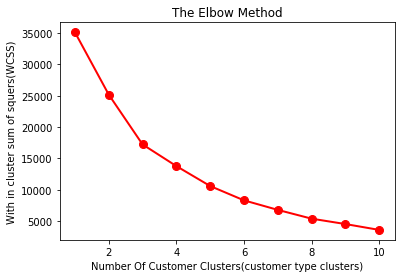

In [0]:
# Feature Scaling

X = informacion_cliente.iloc[:, :].values
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
wcss = [] #With in cluster sum of squers(Inertia)

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss,'ro-', markersize=8, lw=2)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

In [0]:
# Se enviarán 4 grupos ya que es donde se presenta el mayor pliegue
num_clusters= 4

# Normalizo los datos previo a la segmentación
ranking_cliente = informacion_cliente.rank(method='first')
cliente_normalizado = (ranking_cliente - ranking_cliente.mean()) / ranking_cliente.std()
kmeans = KMeans(n_clusters=num_clusters).fit(cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN', 'IMP_VENTA_PROMEDIO']])


cliente_clusters = cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN', 'IMP_VENTA_PROMEDIO']].copy(deep=True)
cliente_clusters['Cluster'] = kmeans.labels_
cliente_clusters.groupby('Cluster').count()['IMP_TOTAL_VENTAS']


Cluster
0    2234
1    2205
2    2123
3    2213
Name: IMP_TOTAL_VENTAS, dtype: int64

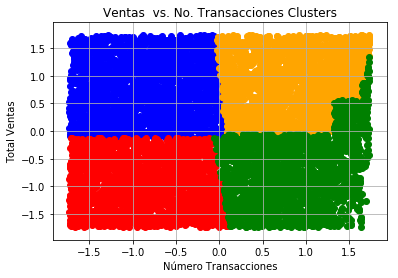

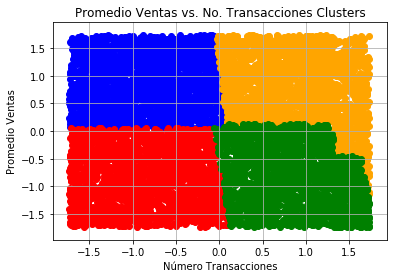

Text(0, 0.5, 'Promedio Ventas')

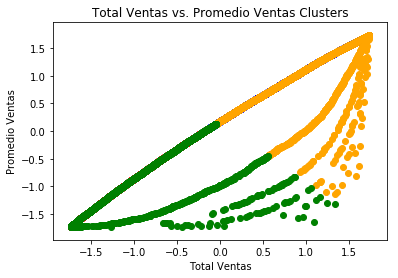

In [0]:
# clustering ventas vs cantidad
plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_TOTAL_VENTAS'],
    c='blue'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_TOTAL_VENTAS'],
    c='red'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_TOTAL_VENTAS'],
    c='orange'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_TOTAL_VENTAS'],
    c='green'
)


plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_TOTAL_VENTAS'],
    c='yellow'
)


plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_TOTAL_VENTAS'],
    c='black'
)


plt.title('Ventas  vs. No. Transacciones Clusters')
plt.xlabel('Número Transacciones')
plt.ylabel('Total Ventas')

plt.grid()
plt.show()

# clustering cantidad vs promedio de facturación
plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_VENTA_PROMEDIO'],
    c='blue'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_VENTA_PROMEDIO'],
    c='red'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_VENTA_PROMEDIO'],
    c='orange'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_VENTA_PROMEDIO'],
    c='green'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_VENTA_PROMEDIO'],
    c='yellow'
)
plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['NUM_TOTAL_TXN'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_VENTA_PROMEDIO'],
    c='black'
)
plt.title('Promedio Ventas vs. No. Transacciones Clusters')
plt.xlabel('Número Transacciones')
plt.ylabel('Promedio Ventas')

plt.grid()
plt.show()
# clustering ventas vs promedio de facturación
plt.scatter(
    
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 0]['IMP_VENTA_PROMEDIO'],
    c='blue'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 1]['IMP_VENTA_PROMEDIO'],
    c='red'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 2]['IMP_VENTA_PROMEDIO'],
    c='orange'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 3]['IMP_VENTA_PROMEDIO'],
    c='green'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 4]['IMP_VENTA_PROMEDIO'],
    c='yellow'
)

plt.scatter(
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_TOTAL_VENTAS'], 
    cliente_clusters.loc[cliente_clusters['Cluster'] == 5]['IMP_VENTA_PROMEDIO'],
    c='black'
)

plt.title('Total Ventas vs. Promedio Ventas Clusters')
plt.xlabel('Total Ventas')
plt.ylabel('Promedio Ventas')



In [0]:
# Se comprueba con el enfoque de Silueta
# identificar el número de clientes por cluster
for n_cluster in [3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN']]
    )
    silhouette_avg = silhouette_score(
        cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN']], 
        kmeans.labels_
    )
    
    print('Scoring silueta para %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Scoring silueta para 3 Clusters: 0.3897
Scoring silueta para 4 Clusters: 0.4107
Scoring silueta para 5 Clusters: 0.3818
Scoring silueta para 6 Clusters: 0.3777
Scoring silueta para 7 Clusters: 0.3733
Scoring silueta para 8 Clusters: 0.3719


### Se integra nueva dimensión de información de segmento

In [0]:
kmeans = KMeans(n_clusters=4).fit(
    cliente_normalizado[['IMP_TOTAL_VENTAS', 'NUM_TOTAL_TXN']]
)
cliente_normalizado['DATA_SEG'] = kmeans.labels_
print(kmeans.cluster_centers_)
cliente_normalizado.head()

[[ 0.82617258 -0.80084865]
 [-0.83113965  0.70407166]
 [-0.89803764 -0.93629123]
 [ 0.90590752  1.01592316]]


,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO,DATA_SEG
customer_id,,,,,
0005ef4cd20d2893f0d9fbd94d3c0d97,0.350141,-1.731755,-1.731755,0.511987,0
001ae5a1788703d64536c30362503e49,0.416853,-1.731360,-1.731360,0.573962,0
0027324a96d26a2bc7d69262f83c8403,-1.245427,-1.730965,-1.730965,-1.138845,2
003035f5ec76f2220098377482de93c9,-0.873180,-1.730571,-1.730571,-0.726729,2
00324c9f4d710e7bac5c5ba679714430,0.066317,-1.730176,1.322797,-0.935550,3


In [0]:
# Se verifica
high_value_cluster = (cliente_normalizado.loc[cliente_normalizado['DATA_SEG'] == 3]).sort_values(ascending=False,by='IMP_TOTAL_VENTAS')
informacion_cliente.loc[high_value_cluster.index].describe()

,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO
count,2.162000e+03,2162.000000,2162.000000,2162.000000
mean,2.757778e+04,1.131822,1.521277,21359.891966
std,4.163867e+04,0.420127,0.926628,27677.573355
min,1.006200e+04,1.000000,1.000000,1808.166667
25%,1.386350e+04,1.000000,1.000000,11271.500000
50%,1.850000e+04,1.000000,1.000000,15224.000000
75%,2.848250e+04,1.000000,2.000000,21651.500000
max,1.366408e+06,6.000000,8.000000,692931.000000


In [0]:
pd.DataFrame(
    datos_facturacion.loc[
        datos_facturacion['customer_id'].isin(high_value_cluster.index)
    ].groupby('product_id').count()[
        'total_value'
    ].sort_values(ascending=False).head()
)

,total_value
product_id,
a62e25e09e05e6faf31d90c6ec1aa3d1,19
d1c427060a0f73f6b889a5c7c61f2ac4,17
422879e10f46682990de24d770e7f83d,17
aca2eb7d00ea1a7b8ebd4e68314663af,14
368c6c730842d78016ad823897a372db,14


# 3. Predicción de Churn con base en el comportamiento de compra

In [0]:
url = 'https://github.com/masdatascience/TFM-AI/blob/master/data_model_completo.xlsx?raw=true'
datos_modelo_completo = pd.ExcelFile(url)
datos_facturacion = pd.read_excel(datos_modelo_completo, sheet_name='fac_txn')
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
datos_facturacion = datos_facturacion.dropna(subset=['customer_id'])
datos_facturacion = datos_facturacion.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
datos_facturacion = datos_facturacion.loc[datos_facturacion['total_value'] > 0]
datos_producto = pd.read_excel(datos_modelo_completo, sheet_name='product')
datos_clientes = pd.read_excel(datos_modelo_completo, sheet_name='customer')

print(datos_producto.shape)
print(datos_clientes.shape)
print(datos_facturacion.shape)



# se visualiza el número de comrpas que tiene un cliente
datos_clientes.groupby('customer_id').size().value_counts()


(32951, 10)
(96352, 4)
(112650, 21)


1    95844
2      248
3        4
dtype: int64

In [0]:
# se eliminan posibles ordenes duplicadas
datos_facturacion.drop_duplicates('order_id',keep='first',inplace=True)
# se convierte la fecha de compra en tipo date para facilitar su gestión
datos_facturacion['date'] = pd.to_datetime(datos_facturacion['order_purchase_timestamp']).dt.date
datos_facturacion = datos_facturacion.drop('order_purchase_timestamp',axis=1)
datos_facturacion.head()

,order_id,order_item_id,product_id,customer_id,customer_zip_code_prefix,shipping_limit_date,price,freight_value,total_value,credit_card,debit_card,boleto,voucher,not_defined,num_txn,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,871766c5855e863f6eccc05f988b23cb,28013,2017-09-19 09:45:35,5890,1329,7219,7219.0,0.0,0.0,0.0,0.0,1.0,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,eb28e67c4c0b83846050ddfb8a35d051,15775,2017-05-03 11:05:13,23990,1993,25983,25983.0,0.0,0.0,0.0,0.0,1.0,delivered,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,3818d81c6709e39d06b2738a8d3a2474,35661,2018-01-18 14:48:30,19900,1787,21687,21687.0,0.0,0.0,0.0,0.0,1.0,delivered,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,af861d436cfc08b2c2ddefd0ba074622,12952,2018-08-15 10:10:18,1299,1279,2578,2578.0,0.0,0.0,0.0,0.0,1.0,delivered,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,64b576fb70d441e8f1b2d7d446e483c5,13226,2017-02-13 13:57:51,19990,1814,21804,21804.0,0.0,0.0,0.0,0.0,1.0,delivered,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02-04


### Se genera el modelo RFM

In [0]:
# se realiza un subconjunto de columnas con los cuales se analizará el comportamiento de compra
transaction_data = datos_facturacion[['customer_id','date','total_value']]
# se crea el modelo RFM
summary = summary_data_from_transaction_data(transaction_data,'customer_id','date',monetary_value_col='total_value',)
# se visualizan los clientes con al menos una compra
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,10328.0
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,4985.0
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,9602.0
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,2678.0
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,8032.0


In [0]:
# Se compara la frecuencia con la información de la facturación
datos_facturacion[datos_facturacion['customer_id']=='065dcef61d5f66b30d2ee51b5343d023']

,order_id,order_item_id,product_id,customer_id,customer_zip_code_prefix,shipping_limit_date,price,freight_value,total_value,credit_card,debit_card,boleto,voucher,not_defined,num_txn,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date
1805,04164ec24abde688d0451ee982797344,1,198ec19b3806cc2ad217e159e4e09d58,065dcef61d5f66b30d2ee51b5343d023,3254,2017-12-06 21:38:22,9500,792,10292,10292.0,0.0,0.0,0.0,0.0,1.0,delivered,2017-12-01 10:31:57,2017-12-01 20:00:26,2017-12-07 00:51:40,2017-12-18,2017-11-30
5214,0bd66289bf194ff3edb0841291f58da1,1,b249cf5fcf68f70e13515489f0fcb627,065dcef61d5f66b30d2ee51b5343d023,3254,2017-04-27 22:50:21,6990,1570,8560,8560.0,0.0,0.0,0.0,0.0,1.0,delivered,2017-04-13 22:50:21,2017-04-20 10:47:48,2017-04-28 09:16:15,2017-05-16,2017-04-13


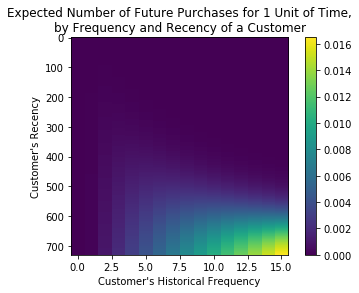

In [0]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
plot_frequency_recency_matrix(bgf);

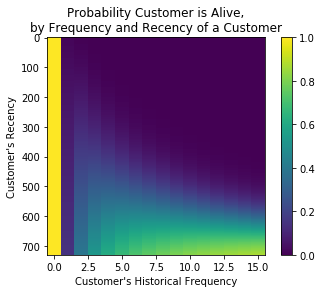

In [0]:
plot_probability_alive_matrix(bgf);

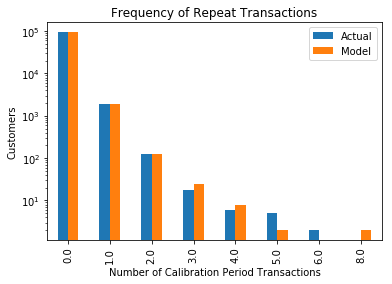

In [0]:
plot_period_transactions(bgf).set_yscale('log');

## ajustes


In [0]:
print(summary.median())
summary[(summary['frequency']<1) & (summary['T']>300) & (summary['recency']<1) & (summary['recency']<0.000044) ].count()/summary.count()

In [0]:
t = 1
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
e0836a97eaae86ac4adc26fbb334a527,2.0,62.0,69.0,3295.50,0.005503
6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,349.0,12037.00,0.005613
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,429.0,10713.60,0.006605
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,255.0,12663.25,0.006981
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,476.0,5861.80,0.022795


In [0]:
summary_cal_holdout = calibration_and_holdout_data(datos_facturacion, 'customer_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )

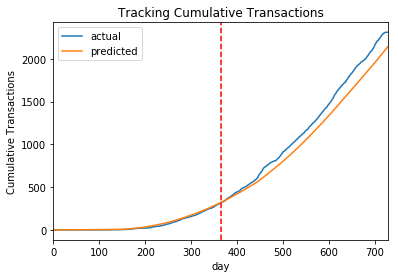

In [0]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);

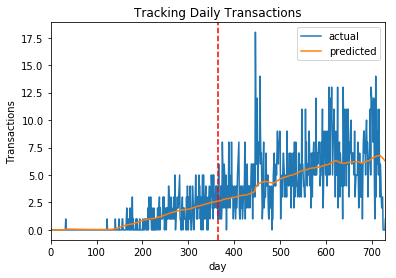

In [0]:
plot_incremental_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);

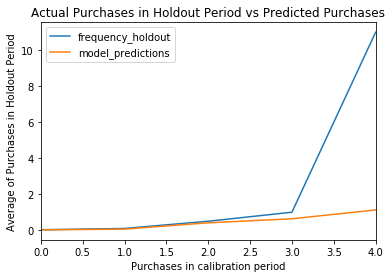

In [0]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

In [0]:
datos_clientes.groupby('customer_id').size().value_counts()

1    95844
2      248
3        4
dtype: int64

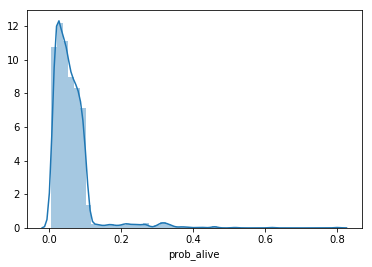

In [0]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);

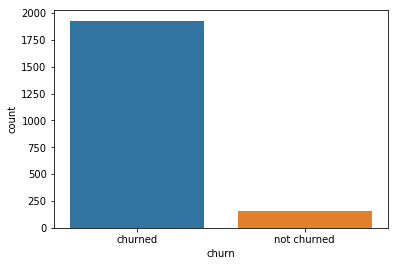

In [0]:
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);

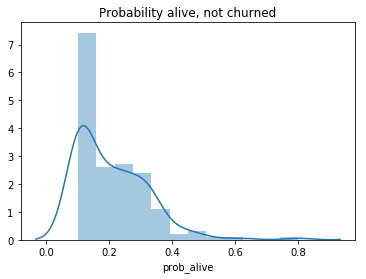

In [0]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');

In [0]:
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()

churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

In [0]:
df[df['churn'] =='churned'].head()

,frequency,recency,T,monetary_value,predicted_purchases,prob_alive,churn
customer_id,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,10328.0,0.000170,0.053200,churned
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,4985.0,0.000271,0.082272,churned
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,9602.0,0.000227,0.033793,churned
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,2678.0,0.000428,0.039748,churned
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,8032.0,0.000286,0.046973,churned


In [0]:
df['definition'] = df['churn'].apply(lambda x: 1 if x == 'churned' else 0)

In [0]:
prueba_clientes = pd.merge(datos_clientes,df[['definition']],on='customer_id', how='left')
prueba_clientes['definition'].fillna(0, inplace=True)
print(prueba_clientes.count())
prueba_clientes.head()

customer_id                 96352
customer_state              96352
customer_city               96352
customer_zip_code_prefix    96352
definition                  96352
dtype: int64


,customer_id,customer_state,customer_city,customer_zip_code_prefix,definition
0,0000366f3b9a7992bf8c76cfdf3221e2,SP,cajamar,7787,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,SP,osasco,6053,0.0
2,0000f46a3911fa3c0805444483337064,SC,sao jose,88115,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,PA,belem,66812,0.0
4,0004aac84e0df4da2b147fca70cf8255,SP,sorocaba,18040,0.0


In [0]:
prueba_clientes['definition'].mean()

0.022293258053802723

In [0]:
# se aplica hot encoded a las dimensiones

# enfoque dos dimensiones
#temporal =  prueba_clientes.drop(['customer_state', 'customer_city'], axis=1)
#customer_state = pd.get_dummies(prueba_clientes.customer_state).iloc[:,1:]
#customer_city = pd.get_dummies(prueba_clientes.customer_city).iloc[:,1:]

# enfoque una dimensión 
temporal =  prueba_clientes.drop(['customer_state'], axis=1)
customer_state = pd.get_dummies(prueba_clientes.customer_state).iloc[:,1:]

In [0]:
def labelDatase(dataset):

  le = preprocessing.LabelEncoder()

  for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass

  return dataset

In [0]:
dataset = labelDatase(temporal)
# con 2 diomensiones 
#customer = pd.concat([temporal,customer_state,customer_city], axis=1)

# con 1 dimensión
customer = pd.concat([dataset,customer_state], axis=1)

customer.head()

,customer_id,customer_city,customer_zip_code_prefix,definition,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,0,655,7787,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,2594,6053,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,3520,88115,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,448,66812,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,3758,18040,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
# se obtiene X y Y , además los datasets de entrenamiento y pruebas
features = customer.drop(['definition'], axis=1)
labels = customer['definition']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=1)

### Random Forest Classifier

In [0]:
# Algoritmo
rfc_object = rfc(n_estimators=200, random_state=0)
rfc_object.fit(train_features, train_labels)
predicted_labels = rfc_object.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18839
         1.0       0.09      0.01      0.01       432

    accuracy                           0.98     19271
   macro avg       0.54      0.50      0.50     19271
weighted avg       0.96      0.98      0.97     19271

[[18810    29]
 [  429     3]]
0.976233719059727


### Support Vector Machines

In [0]:
# Algoritmo
svc_object = svc(kernel='rbf', degree=8)
svc_object.fit(train_features, train_labels)
predicted_labels = svc_object.predict(test_features) 
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18839
         1.0       0.00      0.00      0.00       432

    accuracy                           0.98     19271
   macro avg       0.49      0.50      0.49     19271
weighted avg       0.96      0.98      0.97     19271

[[18839     0]
 [  432     0]]
0.9775828965803539


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Regresión Logistica

In [0]:
# Algoritmo
lr_object = LogisticRegression()
lr_object.fit(train_features, train_labels)
predicted_labels = lr_object.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18839
         1.0       0.00      0.00      0.00       432

    accuracy                           0.98     19271
   macro avg       0.49      0.50      0.49     19271
weighted avg       0.96      0.98      0.97     19271

[[18839     0]
 [  432     0]]
0.9775828965803539


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###Arboles de decisión

In [0]:
from sklearn import tree
import graphviz 
# Create each decision tree (pruned and unpruned)
decisionTree_unpruned = tree.DecisionTreeClassifier()
decisionTree = tree.DecisionTreeClassifier(max_depth = 4)
 
# Fit each tree to our training data
decisionTree_unpruned = decisionTree_unpruned.fit(X=train_features, y=train_labels)
decisionTree = decisionTree.fit(X=train_features, y=train_labels)
 
# Generate PDF visual of decision tree
churnTree = tree.export_graphviz(decisionTree, out_file=None, 
                         feature_names = list(train_features.columns.values),  
                         class_names = ['No churn', 'Churn'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(churnTree)
graph.render('decision_tree.gv', view=True)
predicted_labels = decisionTree.predict(test_features)
# se verifican resultados
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18839
         1.0       0.00      0.00      0.00       432

    accuracy                           0.98     19271
   macro avg       0.49      0.50      0.49     19271
weighted avg       0.96      0.98      0.97     19271

[[18837     2]
 [  432     0]]
0.9774791136941519


###Gradient Boosting Classifier


In [0]:
from sklearn.ensemble import GradientBoostingClassifier

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier()
#Train the model using the training sets
gb.fit(train_features, train_labels)
#Predict the response for test dataset
predicted_labels = gb.predict(test_features)


# Model Accuracy, how often is the classifier correct?
#print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
# Model Precision
#print("Precision:",metrics.precision_score(test_labels, y_pred))
# Model Recall
#print("Recall:",metrics.recall_score(test_labels, y_pred))


print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))
print(accuracy_score(test_labels, predicted_labels))




              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18839
         1.0       0.25      0.01      0.02       432

    accuracy                           0.98     19271
   macro avg       0.61      0.51      0.51     19271
weighted avg       0.96      0.98      0.97     19271

[[18824    15]
 [  427     5]]
0.9770639821493435


### Deep Learning

In [0]:
from keras import models
from keras import layers
sc = StandardScaler()
X_train = sc.fit_transform(train_features)
X_test  = sc.transform(test_features)
#y_train = sc.fit_transform(train_labels)
#y_test  = sc.transform(test_labels)

 
#model = Sequential()
#model.add(Dense(5, input_dim=11, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#y = np.unique(y_train)
tamano_y = len(test_features)
n_cols = train_features.shape[1]

red  =Sequential()
red.add (Dense (256, activation = 'relu', input_shape = (n_cols,))) 
red.add(layers.Dropout(0.25))
red.add (Dense (128, activation = 'relu')) 
red.add(layers.Dropout(0.25))
red.add (Dense (64, activation = 'relu')) 
#red.add(layers.Flatten())
red.add(layers.Dense(tamano_y, activation='linear'))
red.add(layers.Dense(tamano_y, activation='softmax'))

##red.add(layers.Conv2D(4, (3,3), activation='relu', input_shape=(128,128,3)))
#red.add(layers.Conv2D(8, (3,3), activation='relu'))
#red.add(layers.AveragePooling2D((2,2)))
#red.add(layers.Conv2D(32, (3,3), activation='relu'))
#red.add(layers.Dropout(0.25))
#red.add(layers.Conv2D(32, (3,3), activation='relu'))
#red.add(layers.Dropout(0.25))
#red.add(layers.Conv2D(64, (3,3), activation='relu'))
#red.add(layers.Dropout(0.25))
#red.add(layers.Conv2D(64, (3,3), activation='relu'))
#red.add(layers.Dropout(0.25))
#red.add(layers.MaxPooling2D((2,2)))
#red.add(layers.Flatten())
#red.add(layers.Dense(tamano_y, activation='linear'))
#red.add(layers.Dense(tamano_y, activation='softmax'))
# se compila y ejecuta 
red.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#resultado_propia = red.fit_generator(NewData.flow(train_features, test_features,batch_size=34), epochs=10,steps_per_epoch=75,validation_steps=8,validation_data=(x_test, processed_y_test))
#guardarResultado(resultado_propia,red,'EXP1','Propia V1')

resultado_propia =red.fit(train_features, train_labels, batch_size=32, epochs=50)




NameError: ignored

In [0]:
X_dataset.head()

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# Se genera el modelo 
modelo = Sequential()

#Se define un monitor de parada temprana para que el modelo deje de entrenar cuando ya no mejore
early_stopping_monitor = EarlyStopping(patience=3)

#Se obtienen las columnas de entrenamiento

X_dataset = customer.drop (columns= ['customer_id','definition'])
Y_dataset = to_categorical (customer.definition)
n_cols = X_dataset.shape[1]

#Se agregan las capas, aumentar el número de nodos en cada capa aumenta la capacidad del modelo pero por Collab lo dejare en esa cantidad
# La función de activación que utilizaremos es ReLU o activación lineal rectificada. 
# Aunque se trata de dos piezas lineales, se ha demostrado que funciona bien en redes neuronales.

modelo.add (Dense (28, activation = 'sigmoid', input_shape = (n_cols,))) 
modelo.add( Dropout(0.3))
modelo.add (Dense (14, activation = 'sigmoid')) 
modelo.add( Dropout(0.2))
modelo.add (Dense (2, activation = 'sigmoid')) 

#modelo.add(layers.Flatten())
#Una función de activación permite a los modelos tener en cuenta las relaciones no lineales. 
#Por ejemplo, si predice la diabetes en los pacientes, pasar de los 10 a los 11 años es diferente a los de los 60 a los 61 años.
#La activación es 'softmax'. Softmax hace que la sum
  # compilar el modelo utilizando la precisión para medir el rendimiento del modelo 
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resultado=modelo.fit(X_dataset, Y_dataset, batch_size=2, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])
#guardarResultado(resultado,'PROPIA2_EXP1')

#### Matriz de correlación

In [0]:
corr =  customer.drop(['customer_id','definition'], axis=1).corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()